In [4]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [7]:
import numpy as np
import pdb

# my code
from distribution import RBMLatentPosterior, MultivariateBernoulliNoise, ChowLiuTree
from contrastive_divergence_optimiser import CDOptimiser
from fully_observed_models import VisibleRestrictedBoltzmannMachine
from latent_nce_optimiser import LatentNCEOptimiser
from latent_variable_model import RestrictedBoltzmannMachine
from nce_optimiser import NCEOptimiser
from utils import get_true_weights, plot_rbm_parameters, plot_log_likelihood_training_curves, \
rescale_times, average_log_likelihood

from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd

%matplotlib inline
rc('lines', linewidth=1)
rc('font', size=18)
rc('legend', fontsize=18)

# For reproducibility
rng = rnd.RandomState(1083463236)

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# Setup

#### data

In [3]:
n = 10000 # number of datapoints
nz = 1  # number latent samples per datapoint
nu = 1  # ratio of noise to data samples for NCE
num_gibbs_steps_for_synthetic_data = 200

#### model

In [45]:
d = 20  # visible dimension
m = 15  # latent dimension

# true_W = get_true_weights(d, m)
true_W = rng.randn(d+1, m+1)*1 # true setting of the weights, that we are trying to learn
"""true_W = np.array([[0, 0],
                   [-3, 6],
                   [3, -6]], dtype=np.float32)"""
true_W[0, 0] = 0
# theta0 = np.array(true_W)

#### optimisation

In [46]:
# tolerances used to determine when iterations stop in scipy minimize (used in LatentNCEOptimiser)
ftol = 1e-5
maxiter = 20
stop_threshold = 1e-5
max_num_em_steps = 40
opt_method='L-BFGS-B'

# hyperparameters used in CDOptimiser (contrastive divergence optimiser)
cd_num_steps = 1
cd_learn_rate = 0.01
cd_batch_size = 10
cd_num_epochs = 100

time_step_size = 3  # determines how frequently we calculate log-likelihood for plotting optimisation curves

#### boolean switches

In [47]:
optimise_scaling_param_separately = False

use_chow_liu = False
use_marginals = True

assert use_chow_liu != use_marginals

# Data, Model & Optimiser definition

#### sample a synthetic dataset

In [48]:
%%time
true_data_dist = RestrictedBoltzmannMachine(true_W)
X, Z = true_data_dist.sample(n, num_iter=num_gibbs_steps_for_synthetic_data)

CPU times: user 2.1 s, sys: 11.9 ms, total: 2.11 s
Wall time: 2.09 s


In [49]:
# initialise visible biases as recommended by Hinton
X_mean = np.mean(X, axis=0)

In [50]:
theta0 = np.asarray(
    rng.uniform(
        low=-4 * np.sqrt(6. / (d + m)),
        high=4 * np.sqrt(6. / (d + m)),
        size=(d+1, m+1)
    ))
theta0[1:, 0] = np.log(X_mean / (1 - X_mean) + 1e-15)  # visible biases
theta0[0, 0] = -m * np.log(2) + np.sum(np.log(1 - X_mean + 1e-15))  # scaling parameter
theta0[0, 1:] = 0  # hidden biases

#### initialise three models for comparison

In [51]:
model = RestrictedBoltzmannMachine(deepcopy(theta0))
cd_model = RestrictedBoltzmannMachine(deepcopy(theta0))
nce_model = VisibleRestrictedBoltzmannMachine(deepcopy(theta0))
random_init_model = RestrictedBoltzmannMachine(deepcopy(theta0))

#### specify noise distribution

In [52]:
if use_chow_liu:
    noise = ChowLiuTree(X)
if use_marginals:
    noise = MultivariateBernoulliNoise(X_mean)

In [53]:
marginal_noise = MultivariateBernoulliNoise(X_mean)
chow_liu_noise = ChowLiuTree(X)
print('log likelihood of chow liu-tree noise: {}'.format(np.mean(np.log(chow_liu_noise(X)))))
print('log likelihood of marginal noise: {}'.format(np.mean(np.log(marginal_noise(X)))))
print('average prob of data under chow liu-tree noise: {}'.format(np.mean(chow_liu_noise(X))))
print('average prob of data under marginal noise: {}'.format(np.mean(marginal_noise(X))))

log likelihood of chow liu-tree noise: -7.430443111601639
log likelihood of marginal noise: -7.5618032841041805
average prob of data under chow liu-tree noise: 0.0034204127376834927
average prob of data under marginal noise: 0.003001757544732919


#### specify exact posterior distribution

In [54]:
var_dist = RBMLatentPosterior(theta0)  # true posterior, which has an analytic expression

#### construct optimisers

In [55]:
%%time
optimiser = LatentNCEOptimiser(model, noise, var_dist, n, nu=nu, latent_samples_per_datapoint=nz)
cd_optimiser = CDOptimiser(cd_model)
nce_optimiser = NCEOptimiser(nce_model, noise, n, nu=nu)

CPU times: user 4.39 ms, sys: 1.09 ms, total: 5.48 ms
Wall time: 4.5 ms


#### log of true normalisation constant

In [56]:
true_data_dist.reset_norm_const()
true_norm_const = true_data_dist.norm_const
true_W[0, 0] = -np.log(true_norm_const)
print('{:.4f}'.format(-np.log(true_norm_const)))

-44.8952


#### log of normalising constant for random initialisation

In [57]:
random_init_model.reset_norm_const()
rnd_norm_const = random_init_model.norm_const
print('should be reasonably close to 0: {:.4f}'.format(np.log(rnd_norm_const)))

should be reasonably close to 0: 13.2977


#### starting value of scaling parameter

In [58]:
print(theta0[0,0])

-42.22269065585287


# Optimisation

In [18]:
scaling_param_ind = np.array([0])
other_param_inds = np.arange(1, len(model.theta))
all_inds = np.arange(len(model.theta))

#### optimise with respect to scaling parameter, if switch is on

In [19]:
%%time
if optimise_scaling_param_separately:
    thetas_after_em_step_scale_param, J1s_scale, nce_times_scale = \
    optimiser.fit_using_analytic_q(X,
                                   scaling_param_ind, 
                                   theta0=theta0.reshape(-1),
                                   ftol=ftol, 
                                   opt_method=opt_method,
                                   plot=False, 
                                   disp=True)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs


In [20]:
if optimise_scaling_param_separately:
    fig = optimiser.plot_loss_curve(J1s_scale, true_theta = true_W.reshape(-1), X=X)

#### optimise with respect to all parameters

In [21]:
%%time
thetas_after_em_step, J1s, nce_times = optimiser.fit_using_analytic_q(X, 
                                                                      theta0=model.theta,
                                                                      ftol=ftol, 
                                                                      maxiter=maxiter,
                                                                      stop_threshold=stop_threshold,
                                                                      max_num_em_steps=max_num_em_steps,
                                                                      opt_method=opt_method,
                                                                      disp=True, 
                                                                      plot=False)
latent_nce_estimate = deepcopy(model.theta)

1 EM step: J1 = -1.4797173754696513
2 EM step: J1 = -1.3815109593030728
3 EM step: J1 = -1.362952096882444
4 EM step: J1 = -1.3517776112218822
5 EM step: J1 = -1.3463050408834487
6 EM step: J1 = -1.3421660411176153
7 EM step: J1 = -1.3392382275932952
8 EM step: J1 = -1.3366105699210769
9 EM step: J1 = -1.33526611016321
10 EM step: J1 = -1.3341354231486822
11 EM step: J1 = -1.3326799483865677
12 EM step: J1 = -1.3311950408270077
13 EM step: J1 = -1.3308316991026399
14 EM step: J1 = -1.330396493202466
15 EM step: J1 = -1.3300820773923006
16 EM step: J1 = -1.3291141396418809
17 EM step: J1 = -1.3288550185609735
18 EM step: J1 = -1.328695867525036
19 EM step: J1 = -1.3285935461644538
20 EM step: J1 = -1.32780428469894
21 EM step: J1 = -1.3272566669180472
22 EM step: J1 = -1.327179910419841
23 EM step: J1 = -1.3267188526311124
24 EM step: J1 = -1.3266458877856784
25 EM step: J1 = -1.3265778492796927
26 EM step: J1 = -1.3266405793511387
27 EM step: J1 = -1.3264275553268743
28 EM step: J1 = -

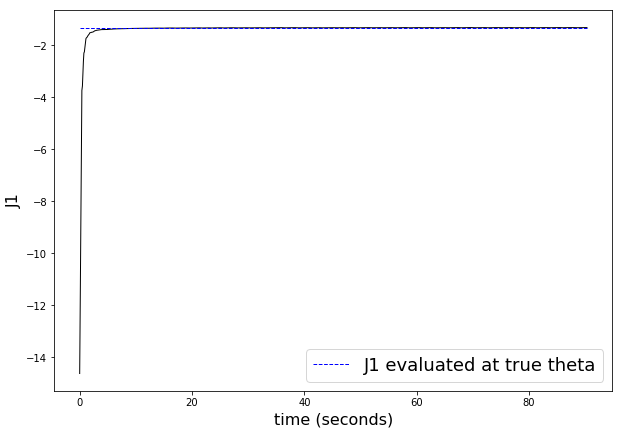

In [22]:
optimal_J1 = optimiser.evaluate_J1_at_param(theta=true_W.reshape(-1), X=X)
fig = optimiser.plot_loss_curve(maxiter=None, optimal_J1=optimal_J1)

#### learn parameters using standard NCE

CPU times: user 3min 41s, sys: 34.2 ms, total: 3min 41s
Wall time: 3min 41s


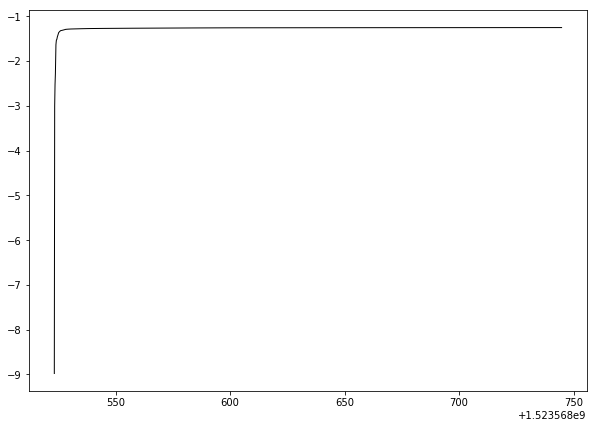

In [59]:
%%time
nce_thetas, nce_Js, nce_times = nce_optimiser.fit(X, theta0=theta0.reshape(-1))
nce_estimate = deepcopy(nce_model.theta)

#### learn parameters using contrastive divergence

In [24]:
%%time
thetas_after_each_minibatch, cd_times = cd_optimiser.fit(X, 
                                                         theta0=theta0.reshape(-1), 
                                                         num_gibbs_steps=cd_num_steps,
                                                         learning_rate=cd_learn_rate, 
                                                         batch_size=cd_batch_size, 
                                                         num_epochs=cd_num_epochs)
cd_estimate =  deepcopy(cd_model.theta)

CPU times: user 18 s, sys: 108 ms, total: 18.1 s
Wall time: 18.1 s


# Results

## Log-likelihood on training set

### $ \mathbb{E}_{x \sim P_{data}} \log(P_{data}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{lnce}(x)) \ \ \text{and} \ \ \mathbb{E}_{x \sim P_{data}} \log(P_{cd}(x))  $

In [25]:
%%time
true_dist_probs_of_true_data, _ = true_data_dist.normalised_and_marginalised_over_z(X)
latent_nce_probs_of_true_data, _ = model.normalised_and_marginalised_over_z(X)
cd_probs_of_true_data, _ = cd_model.normalised_and_marginalised_over_z(X)
nce_probs_of_true_data = nce_model(X, normalise=True)
random_probs_of_true_data, _ = random_init_model.normalised_and_marginalised_over_z(X)
print('True:       {:.4f} \nLatent NCE: {:.4f} \nCD:         {:.4f}'
      '\nNCE:         {:.4f}\nRandom init:{:.4f} \nNoise:      {:.4f}'.format(
    np.mean(np.log(true_dist_probs_of_true_data)), 
    np.mean(np.log(latent_nce_probs_of_true_data)),
    np.mean(np.log(cd_probs_of_true_data)),
    np.mean(np.log(nce_probs_of_true_data)),
    np.mean(np.log(random_probs_of_true_data)),
    np.mean(np.log(noise(X)))
))

True:       -6.5184 
Latent NCE: -6.5340 
CD:         -6.5321
NCE:         -8.1835
Random init:-17.0687 
Noise:      -6.6532
CPU times: user 737 ms, sys: 99.6 ms, total: 837 ms
Wall time: 821 ms


In [26]:
optimiser.times = optimiser.times[::time_step_size]
optimiser.J1s = optimiser.J1s[::time_step_size]
optimiser.thetas = optimiser.thetas[::time_step_size]

# rescale cd timings so they are comparable to lnce timings
cd_optimiser.times, cd_time_ids = rescale_cd_times(deepcopy(optimiser.times),
                                                   deepcopy(cd_optimiser.times))
cd_optimiser.thetas = cd_optimiser.thetas[cd_time_ids]

nce_optimiser.times = nce_optimiser.times[::time_step_size]
nce_optimiser.Js = nce_optimiser.Js[::time_step_size]
nce_optimiser.thetas = nce_optimiser.thetas[::time_step_size]

In [27]:
av_log_like_lnce = optimiser.av_log_like_for_each_iter(X)
av_log_like_cd = cd_optimiser.av_log_like_for_each_iter(X)
av_log_like_nce = nce_optimiser.av_log_like_for_each_iter(X)
true_log_like = average_log_likelihood(true_data_dist, X)
init_log_like = average_log_likelihood(random_init_model, X)
noise_log_like = np.mean(np.log(noise(X)))

In [28]:
training_curves = [(optimiser.times, av_log_like_lnce, 'lnce'), 
                  (cd_optimiser.times, av_log_like_cd, 'cd'), 
                  (nce_optimiser.times, av_log_like_nce, 'nce')]
static_lines = [(true_log_like, 'true'),
               (init_log_like, 'initial'),
               (noise_log_like, 'noise')]

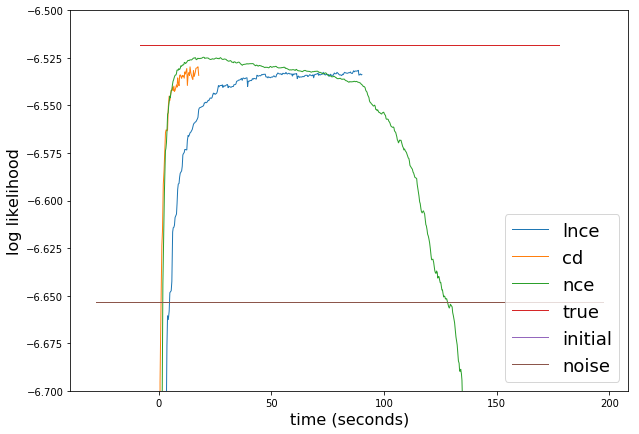

In [43]:
fig = plot_log_likelihood_training_curves(training_curves, static_lines)
ax = fig.gca()
ax.set_ylim(-6.7, -6.5)
ax.legend(loc='lower right')

### Scaling parameter

In [30]:
print('Learnt Scaling param is:              {:.4f}'.format(latent_nce_estimate[0]))
print('log of norm const of data distribution is:   {:.4f}'.format(-np.log(true_norm_const)))

Learnt Scaling param is:              -27.3175
log of norm const of data distribution is:   -29.0998


In [31]:
model.reset_norm_const()
print('We hope that the normalisation constant of the learnt model is 1. In reality it is: {} '.format(
    model.norm_const))

We hope that the normalisation constant of the learnt model is 1. In reality it is: 1.0250635645870454 


## Visualisations of parameters

In [32]:
params = [true_data_dist.theta, model.theta, cd_model.theta, random_init_model.theta]
titles = ['True parameters', 'Latent NCE parameters',  
          'Contrastive divergence parameters', 'Randomly initialised parameters']

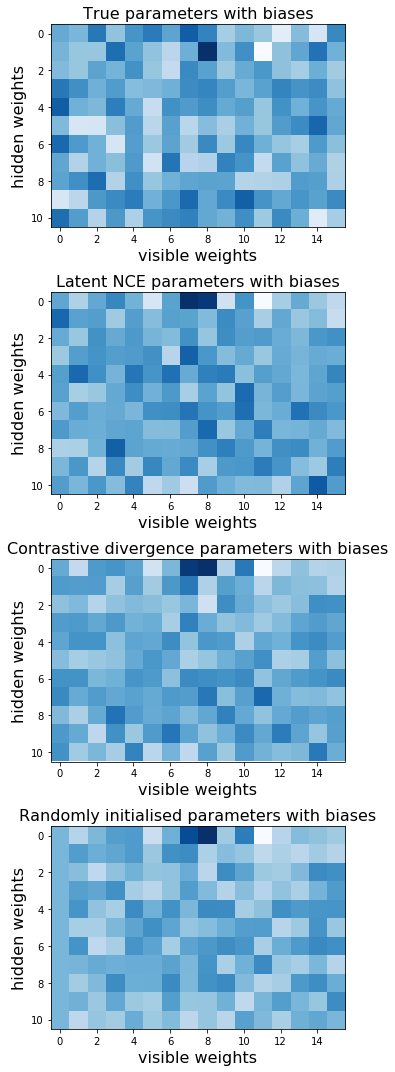

In [33]:
fig = plot_rbm_parameters(params, titles, d, m, with_bias=False, figsize=(10, 15))

## Frobenius norm of true parameters minus model parameters

In [34]:
# NOTE: we exclude the scaling parameter in all comparisons

nce_true_param_diff = (true_W - latent_nce_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_nce_true = np.dot(nce_true_param_diff, nce_true_param_diff)**0.5

cd_true_param_diff = (true_W - cd_estimate.reshape(d+1, m+1)).reshape(-1)[1:]
sq_diff_cd_true = np.dot(cd_true_param_diff, cd_true_param_diff)**0.5

random_true_param_diff = (true_W - theta0).reshape(-1)[1:]
sq_diff_rand_true = np.dot(random_true_param_diff, random_true_param_diff)**0.5

nce_cd_param_diff = (latent_nce_estimate - cd_estimate)[1:]
sq_diff_nce_cd = np.dot(nce_cd_param_diff, nce_cd_param_diff)**0.5

print('true vs latent nce:   {:.4f}'.format(sq_diff_nce_true))
print('true vs cd:           {:.4f}'.format(sq_diff_cd_true))
print('true vs random init:  {:.4f}'.format(sq_diff_rand_true))
print('nce vs cd:            {:.4f}'.format(sq_diff_nce_cd))

true vs latent nce:   19.9346
true vs cd:           19.4924
true vs random init:  21.2803
nce vs cd:            9.8361


## Histograms of posterior distribution during learning

In [35]:
thetas = list(thetas_after_em_step)
thetas.append(true_W.reshape(-1))
num_thetas = len(thetas)

In [36]:
if m <= 5:    
    all_latents = model.get_all_binary_vectors(m)
    all_latents_tiled = np.repeat(all_latents, len(X)).reshape(len(all_latents), len(X), m)
    fig, axs = plt.subplots(int(np.ceil(num_thetas/4)), 4, figsize=(15, 7))
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        if i == num_thetas:
            break
        theta_i = thetas[i]
        var_dist.alpha = theta_i.reshape(-1)
        var_dist_probs = var_dist(all_latents_tiled, X)
        ax.hist(var_dist_probs.reshape(-1), bins=int(0.1*var_dist_probs.size**0.5))
        ax.set_yticks([])

## L1 norm between model joint & true joint

$$ \| \phi - p_{data} \|_1 = \sum_{\textbf{v} \in \{0,1\}^{d}} \sum_{\textbf{h} \in \{0,1\}^{m}} |\phi(\textbf{v}, \textbf{h}) - p_{data}(\textbf{v}, \textbf{h}) | $$

In [37]:
true_model_vals = true_data_dist.evaluate_on_entire_domain(normalise=True)
latent_nce_vals = model.evaluate_on_entire_domain(normalise=False)
cd_vals = cd_model.evaluate_on_entire_domain(normalise=True)
rnd_init_vals = random_init_model.evaluate_on_entire_domain(normalise=True)

l1_norm_diff_true_nce = np.sum(np.abs(true_model_vals - latent_nce_vals))
l1_norm_diff_true_cd = np.sum(np.abs(true_model_vals - cd_vals))
l1_norm_diff_true_rnd_init = np.sum(np.abs(true_model_vals - rnd_init_vals))

print('||true - latent nce||:   {:.4f}'.format(l1_norm_diff_true_nce))
print('||true - cd||:           {:.4f}'.format(l1_norm_diff_true_cd))
print('||true - random init||:  {:.4f}'.format(l1_norm_diff_true_rnd_init))

AssertionError: Evaluating over the whole domain has O(2**(m+d)) cost. Assertion raised since m+d is equal to 25, which exceeds the current limit of 20

### log-likelihood assigned to noise

In [ ]:
print(
'Under noise dist:   {} '
'\nUnder true dist:    {} '
'\nUnder learnt model: {}'.format(
    np.mean(np.log(noise(optimiser.Y))), 
    np.mean(np.log(true_data_dist.normalised_and_marginalised_over_z(optimiser.Y)[0])),
    np.mean(np.log(model.normalised_and_marginalised_over_z(optimiser.Y)[0]))                  
    )
)

# Validation of synthetic dataset

In [ ]:
"""all_visibles = true_data_dist.get_all_binary_vectors(d)
visible_probs, true_dist_norm_const = true_data_dist.normalised_and_marginalised_over_z(all_visibles)
print('Sum over all visible probabilities should equal 1. We got: {}'.format(sum(visible_probs)))

print('-------------------------Visible probability checks--------------------------------------')
for i in range(2**d):
    freq = np.sum(np.product((X == all_visibles[i]), axis=-1))/ len(X)
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_visibles[i], 
                                                                         freq, visible_probs[i]))
print('normalisation constant is: {}'.format(true_dist_norm_const))

all_hiddens = true_data_dist.get_all_binary_vectors(m)
hidden_probs, _ = true_data_dist.normalised_and_marginalised_over_u(all_hiddens)

print('Sum over all hidden probabilities should equal 1. We got: {}'.format(sum(hidden_probs)))

var_dist.alpha = true_W.reshape(-1)
Z_from_posterior_class = var_dist.sample(1000, X)

print('-------------------------Hidden probability checks--------------------------------------')
for i in range(2**m):
    freq = np.mean(np.product((Z_from_posterior_class == all_hiddens[i]), axis=(-1)))
    print('{}:  Empirical frequency is {}. True probability is {}'.format(all_hiddens[i], 
                                                                         freq, hidden_probs[i]))"""